In [34]:
from __future__ import absolute_import, division, print_function
import numpy as np
import pandas as pd 
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [4]:
print(os.listdir('MalariaCell/'))

['Uninfected', 'Parasitized']


In [5]:
infected = os.listdir('MalariaCell/Parasitized/') 
uninfected = os.listdir('MalariaCell//Uninfected/')

In [7]:
data = []
labels = []
for i in infected:
    try:    
        image = cv2.imread('MalariaCell/Parasitized/'+i)
        image_array = Image.fromarray(image, 'RGB')
        resize_img = image_array.resize((50, 50))
        rotated45 = resize_img.rotate(45)
        rotated75 = resize_img.rotate(75)
        blur = cv2.blur(np.array(resize_img),(10,10))
        data.append(np.array(resize_img))
        data.append(np.array(rotated45))
        data.append(np.array(rotated75))
        data.append(np.array(blur))
        labels.append(1)
        labels.append(1)
        labels.append(1)
        labels.append(1)        
    except AttributeError:
        print('')
    
for u in uninfected:
    try:        
        image = cv2.imread('MalariaCell//Uninfected/'+u)
        image_array = Image.fromarray(image , 'RGB')
        resize_img = image_array.resize((50 , 50))
        rotated45 = resize_img.rotate(45)
        rotated75 = resize_img.rotate(75)
        data.append(np.array(resize_img))
        data.append(np.array(rotated45))
        data.append(np.array(rotated75))
        labels.append(0)
        labels.append(0)
        labels.append(0)        
    except AttributeError:
        print('')

In [9]:
cells = np.array(data)
labels = np.array(labels)
np.save('Cells', cells)
np.save('Labels', labels)
print('Cells : {} | labels : {}'.format(cells.shape, labels.shape))

Cells : (96453, 50, 50, 3) | labels : (96453,)


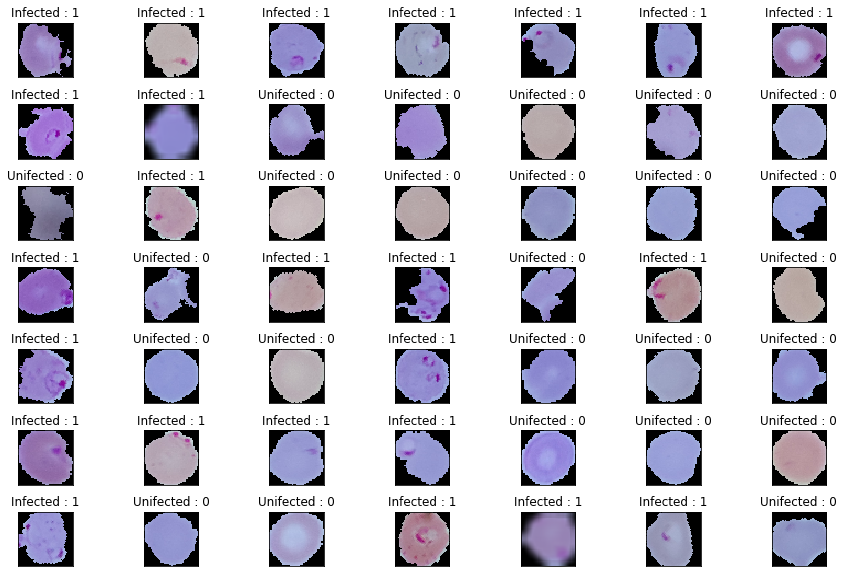

In [11]:
plt.figure(1, figsize = (15, 10))
n = 0 
for i in range(49):
    n += 1 
    r = np.random.randint(0, cells.shape[0] , 1)
    plt.subplot(7, 7, n)
    plt.subplots_adjust(hspace = 0.5, wspace = 0.5)
    plt.imshow(cells[r[0]])
    plt.title('{} : {}'.format('Infected' if labels[r[0]] == 1 else 'Unifected',
                               labels[r[0]]) )
    plt.xticks([]) , plt.yticks([])    
plt.show()

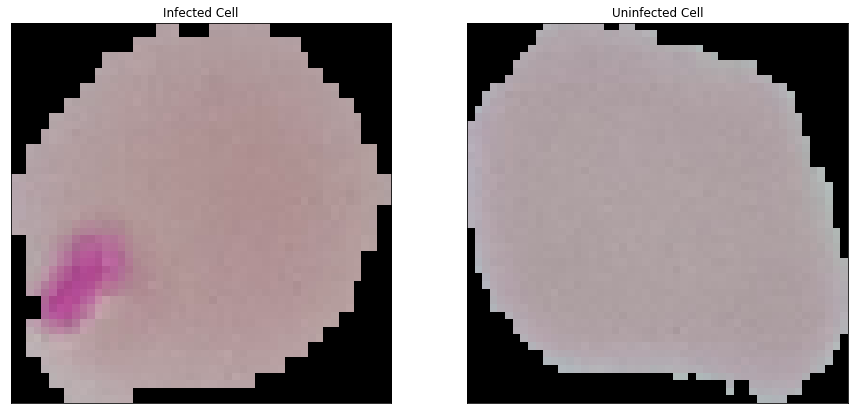

In [12]:
plt.figure(1, figsize = (15 , 7))
plt.subplot(1 , 2 , 1)
plt.imshow(cells[0])
plt.title('Infected Cell')
plt.xticks([]) , plt.yticks([])
plt.show()

plt.subplot(1 , 2 , 2)
plt.imshow(cells[60000])
plt.title('Uninfected Cell')
plt.xticks([]) , plt.yticks([])
plt.show()

In [13]:
n = np.arange(cells.shape[0])
np.random.shuffle(n)
cells = cells[n]
labels = labels[n]

In [14]:
cells = cells.astype(np.float32)
labels = labels.astype(np.int32)
cells = cells/255

In [17]:
train_x, x, train_y, y = train_test_split(cells,labels,test_size = 0.2,random_state = 111)
eval_x, test_x, eval_y, test_y = train_test_split(x,y,test_size = 0.5,random_state = 111)

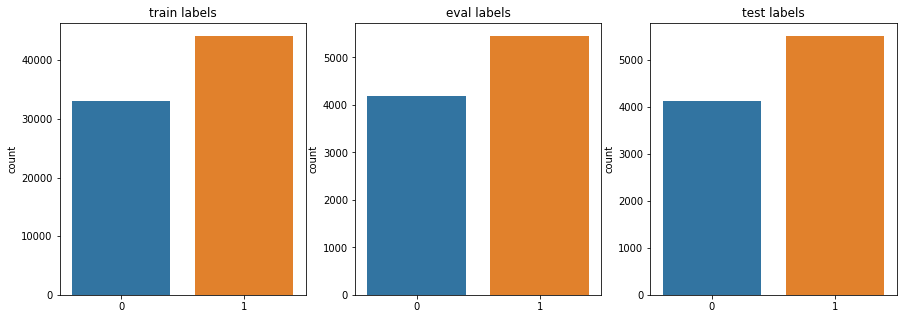

In [18]:
plt.figure(1, figsize = (15 ,5))
n = 0 
for z, j in zip([train_y, eval_y, test_y],['train labels','eval labels','test labels']):
    n += 1
    plt.subplot(1, 3, n)
    sns.countplot(x = z )
    plt.title(j)
plt.show()

In [21]:
print('train data shape:{},eval data shape:{}, test data shape:{}'.format(train_x.shape,
                                                          eval_x.shape,test_x.shape))

train data shape:(77162, 50, 50, 3),eval data shape:(9645, 50, 50, 3), test data shape:(9646, 50, 50, 3)


In [22]:
tf.reset_default_graph()
def cnn_model_fn(features, labels, mode):
    input_layers = tf.reshape(features['x'], [-1 , 50 , 50 ,3])    
    conv1 = tf.layers.conv2d( inputs = input_layers,filters = 50, 
        kernel_size = [7 , 7], padding = 'same', activation = tf.nn.relu) 
    
    conv2 = tf.layers.conv2d(
        inputs = conv1,filters = 90,kernel_size = [3 , 3],
        padding = 'valid',activation = tf.nn.relu)
    
    conv3 = tf.layers.conv2d(
        inputs = conv2,filters = 10,kernel_size = [5 , 5],
        padding = 'same',activation = tf.nn.relu)
    
    pool1 = tf.layers.max_pooling2d(inputs = conv3, pool_size = [2, 2], strides = 2)
    conv4 = tf.layers.conv2d(
        inputs = pool1,filters = 5,kernel_size = [3 , 3],
        padding = 'same',activation = tf.nn.relu)

    pool2 = tf.layers.max_pooling2d(inputs = conv4, pool_size = [2, 2],strides = 2,
                                    padding = 'same')    
    pool2_flatten = tf.layers.flatten(pool2)
    fc1 = tf.layers.dense(
        inputs = pool2_flatten,units = 2000,activation = tf.nn.relu)
    fc2 = tf.layers.dense(
        inputs = fc1,units = 1000,activation = tf.nn.relu)
    fc3 = tf.layers.dense(
        inputs = fc2,units = 500,activation = tf.nn.relu)
    logits = tf.layers.dense(inputs = fc3, units = 2)
    
    predictions = {
        'classes': tf.argmax(input = logits , axis = 1),
        'probabilities': tf.nn.softmax(logits , name = 'softmax_tensor')}
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode = mode, predictions = predictions)
    
    loss = tf.losses.sparse_softmax_cross_entropy(labels = labels, logits = logits)
    
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate = 0.001)
        train_op = optimizer.minimize(loss = loss, global_step = tf.train.get_global_step())        
        return tf.estimator.EstimatorSpec(mode = mode, loss = loss, train_op = train_op)
    
    eval_metric_op = {'accuracy' : tf.metrics.accuracy(labels = labels,
                                         predictions =  predictions['classes'])}
    
    return tf.estimator.EstimatorSpec(mode = mode, loss = loss,
                                      eval_metric_ops = eval_metric_op)

In [24]:
malaria_detector = tf.estimator.Estimator(model_fn = cnn_model_fn, 
                                         model_dir = 'tmp/modelchkpt')

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'tmp/modelchkpt', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fe17d04b828>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [25]:
tensors_to_log = {'probabilities':'softmax_tensor'}
logging_hook = tf.train.LoggingTensorHook(
    tensors = tensors_to_log, every_n_iter = 5)

In [26]:
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x = {'x': train_x}, y = train_y, batch_size = 100, num_epochs = None,shuffle = True)

In [28]:
malaria_detector.train(input_fn = train_input_fn, steps = 1, hooks = [logging_hook])

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tmp/modelchkpt/model.ckpt-1
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into tmp/modelchkpt/model.ckpt.
INFO:tensorflow:probabilities = [[0.4837707  0.5162293 ]
 [0.48460296 0.5153971 ]
 [0.4885184  0.51148164]
 [0.4858121  0.5141879 ]
 [0.49233663 0.50766337]
 [0.4853888  0.5146112 ]
 [0.48486635 0.5151337 ]
 [0.48100603 0.518994  ]
 [0.48521808 0.5147819 ]
 [0.48866767 0.51133233]
 [0.48545605 0.51454395]
 [0.49384558 0.5061544 ]
 [0.48810542 0.5118946 ]
 [0.48899883 0.5110012 ]
 [0.48810047 0.51189953]
 [0.4877865  0.51221347]
 [0.4881812  0.5118188 ]
 [0.48210895 0.51789105]
 [0.48884013 0.5111599 ]
 [0.48689547 0.51310456]
 [0.48625383 0.5137462 ]
 [0.49145916 0.50854087]
 [0.49259803 0.507402  ]
 [0.4872921  

In [29]:
malaria_detector.train(input_fn = train_input_fn , steps = 10000)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tmp/modelchkpt/model.ckpt-2
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 2 into tmp/modelchkpt/model.ckpt.
INFO:tensorflow:loss = 0.69015646, step = 2
INFO:tensorflow:global_step/sec: 2.17527
INFO:tensorflow:loss = 0.6835869, step = 102 (45.974 sec)
INFO:tensorflow:global_step/sec: 2.15995
INFO:tensorflow:loss = 0.70311636, step = 202 (46.296 sec)
INFO:tensorflow:global_step/sec: 2.16848
INFO:tensorflow:loss = 0.68845135, step = 302 (46.117 sec)
INFO:tensorflow:global_step/sec: 2.17413
INFO:tensorflow:loss = 0.66657585, step = 402 (45.994 sec)
INFO:tensorflow:global_step/sec: 2.16573
INFO:tensorflow:loss = 0.678411, step = 502 (46.173 sec)
INFO:tensorflow:global_step/sec: 2.16654
INFO:tensorflow:loss = 0.69888294, ste

KeyboardInterrupt: 

In [30]:
pred_input_fn = tf.estimator.inputs.numpy_input_fn(
    x = {'x' : test_x}, y = test_y, num_epochs = 1, shuffle = False )

In [31]:
y_pred = malaria_detector.predict(input_fn = pred_input_fn)
classes = [p['classes'] for p in y_pred]

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tmp/modelchkpt/model.ckpt-1301
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [35]:
print('{} \n{} \n{}'.format(confusion_matrix(test_y, classes), 
                           classification_report(test_y, classes),
                            accuracy_score(test_y,classes)))

[[   0 4128]
 [   0 5518]] 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      4128
           1       0.57      1.00      0.73      5518

   micro avg       0.57      0.57      0.57      9646
   macro avg       0.29      0.50      0.36      9646
weighted avg       0.33      0.57      0.42      9646
 
0.5720505909185154


/home/nebex/usys/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/nebex/usys/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/nebex/usys/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


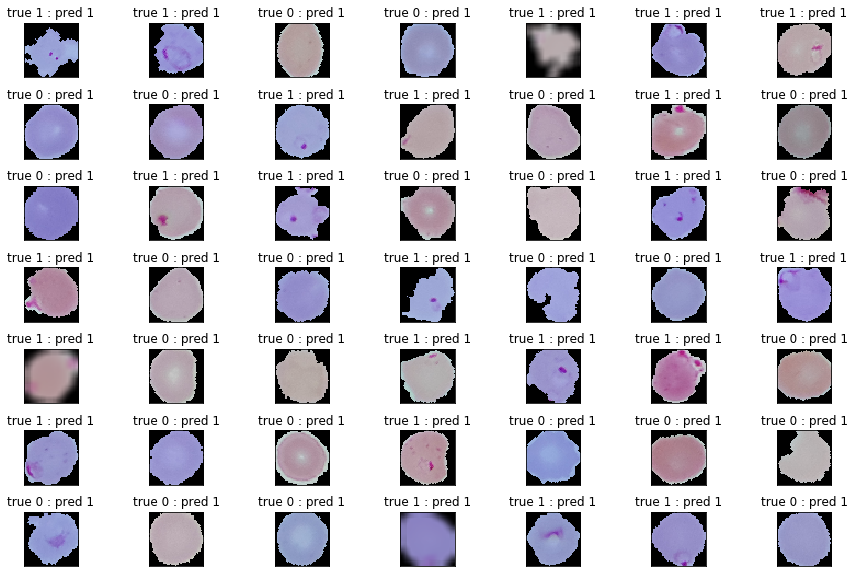

In [33]:
plt.figure(1 , figsize = (15 , 10))
n = 0 
for i in range(49):
    n += 1 
    r = np.random.randint( 0  , test_x.shape[0] , 1)
    plt.subplot(7 , 7 , n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    plt.imshow(test_x[r[0]])
    plt.title('true {} : pred {}'.format(test_y[r[0]] , classes[r[0]]) )
    plt.xticks([]) , plt.yticks([])
plt.show()